In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

In [2]:
train_data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv('./data/test.csv')

print(train_data.head())
print(test_data.head())

   time         A         B         C         D         E         F         G  \
0     0  0.207366 -0.159951 -0.634176 -0.580962 -0.266505  0.060173 -0.475257   
1     1  0.188828 -0.265508  0.042143 -0.550442 -0.132319 -0.185219  0.028295   
2     2 -0.144261 -0.577142 -0.214634 -0.747391 -0.184255 -0.464831 -0.085181   
3     3  0.208982 -0.310449  0.513708 -0.562868  0.742308 -0.305487  0.762246   
4     4  0.093320 -0.358156  0.173188 -0.687296 -0.161461 -0.116062 -0.245748   

          H         I         J         K         L         M         N  \
0 -1.486516 -0.332594 -0.671466 -0.226149 -0.187624 -0.780237 -0.785965   
1  0.093210 -0.518139 -0.251917 -0.347845 -0.359069 -0.161254  0.020401   
2  0.700449 -0.603438  0.197773 -0.566696 -0.580799  0.202726  0.135261   
3  1.363020 -0.384575  0.525556 -0.348514 -0.428099  0.548993  0.471031   
4  0.863372 -0.655588 -0.263358 -0.557428 -0.481214  0.083602  0.003087   

         Y1        Y2  
0 -0.935902 -0.310081  
1 -0.089707 -0

In [3]:
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [4]:
# indicator for regime
train_data['post_10k'] = (train_data['time'] >= 10_000).astype(int)

# interactions so Elastic Net can pick different slopes
train_data['A_post'] = train_data['A'] * train_data['post_10k']
train_data['A_pre']  = train_data['A'] * (1 - train_data['post_10k'])

In [5]:
# indicator for regime
test_data['post_10k'] = (test_data['time'] >= 10_000).astype(int)

# interactions so Elastic Net can pick different slopes
test_data['A_post'] = test_data['A'] * test_data['post_10k']
test_data['A_pre']  = test_data['A'] * (1 - test_data['post_10k'])

In [6]:
test_data.head()

,id,time,A,B,C,D,E,F,G,H,I,J,K,L,M,N,post_10k,A_post,A_pre
0,1,80005,-0.371888,-0.273485,0.538326,-0.377691,1.283159,-0.286957,0.439415,0.020831,-0.295480,0.117643,-0.369900,-0.378902,0.470166,0.411796,1,-0.371888,-0.0
1,2,80006,-0.459598,-0.514915,-0.235153,-0.262379,0.044343,-0.429888,-0.059034,-0.725713,-0.407681,-0.255702,-0.461901,-0.249516,-0.216745,-0.328599,1,-0.459598,-0.0
2,3,80007,-0.381609,-0.265023,-0.629131,-0.186288,-0.146302,-0.357875,0.114223,-0.359341,-0.190712,-0.404083,-0.272153,-0.193158,-0.679351,-0.476331,1,-0.381609,-0.0
3,4,80008,-0.371423,-0.106279,-1.142702,-0.200429,-0.176918,-0.354048,-0.230199,-0.305226,0.185342,-0.333010,0.518678,-0.028775,-0.610620,-0.846772,1,-0.371423,-0.0
4,5,80009,-0.309393,-0.015144,-1.099371,-0.405841,-0.239068,-0.403306,-0.983134,-1.067315,-0.105132,-0.809948,0.185197,-0.150254,-1.080190,-0.685936,1,-0.309393,-0.0


In [7]:
cutoff = 64000

In [8]:
import numpy as np
scaler = StandardScaler()
ridge = Pipeline([("scale", scaler), ("ridge", RidgeCV(alphas=np.logspace(-3, 3, 20)))])
lasso = Pipeline([("scale", scaler), ("lasso", LassoCV(alphas=np.logspace(-3, 3, 20), cv=TimeSeriesSplit(n_splits=5)))])
elastic = Pipeline([
    ("scale", scaler),
    ("elastic", ElasticNetCV(
        alphas=np.logspace(-3, 3, 20),
        l1_ratio=[1.0],  # search over mixes (0<l1_ratio<=1)
        cv=TimeSeriesSplit(n_splits=5),
        n_jobs=-1
    ))
])
pca_regression = Pipeline([("scale", scaler), ("PCA", PCA(n_components=0.95)), ("regression", LinearRegression())])
tscv = TimeSeriesSplit(n_splits=5)
models = {
    "Lasso": lasso,
    "Ridge": ridge, 
    "PCA + Regression": pca_regression,
    "Elastic": elastic
}
features = ['K', 'B', 'D', 'L', 'I', 'F', 'A_pre', 'A_post', 'post_10k', 'time']
features = features
print(len(features))
X = train_data[features].iloc[:cutoff]
y = train_data["Y2"].iloc[:cutoff]
results = {}
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=tscv, scoring="r2")
    results[name] = scores
    print(f"{name} had r2 score mean {scores.mean()} and score std {scores.std()}")

10
Lasso had r2 score mean 0.6469199761203704 and score std 0.07079341832043068
Ridge had r2 score mean 0.6250127523510116 and score std 0.11414796202134493
PCA + Regression had r2 score mean 0.4729451096753601 and score std 0.17918574355001426
Elastic had r2 score mean 0.6469199761203704 and score std 0.07079341832043068


In [18]:
train_data[features].iloc[:cutoff].head()

,K,B,D,L,I,F,A_pre,A_post,post_10k,time
0,-0.226149,-0.159951,-0.580962,-0.187624,-0.332594,0.060173,0.207366,0.0,0,0
1,-0.347845,-0.265508,-0.550442,-0.359069,-0.518139,-0.185219,0.188828,0.0,0,1
2,-0.566696,-0.577142,-0.747391,-0.580799,-0.603438,-0.464831,-0.144261,-0.0,0,2
3,-0.348514,-0.310449,-0.562868,-0.428099,-0.384575,-0.305487,0.208982,0.0,0,3
4,-0.557428,-0.358156,-0.687296,-0.481214,-0.655588,-0.116062,0.093320,0.0,0,4


In [10]:
elastic.fit(train_data[features].iloc[:cutoff], train_data["Y2"].iloc[:cutoff])

,steps,"[('scale', ...), ('elastic', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,l1_ratio,[1.0]
,eps,0.001
,n_alphas,'deprecated'
,alphas,array([1.0000...00000000e+03])


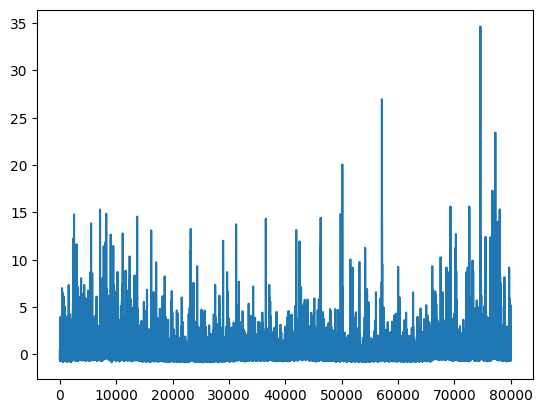

In [11]:
plt.plot(train_data['Y2'])

In [12]:
enet = elastic.named_steps["elastic"]          
sc   = elastic.named_steps["scale"]           

print("alpha_*     :", enet.alpha_)
print("l1_ratio_*  :", enet.l1_ratio_)
print("n_alphas    :", len(enet.alphas_))
print("coef (std.) :", enet.coef_)
print("intercept   :", enet.intercept_)

alpha_*     : 0.008858667904100823
l1_ratio_*  : 1.0
n_alphas    : 20
coef (std.) : [0.08191977 0.05443845 0.07846182 0.05065353 0.04454431 0.05649138
 0.30813836 0.383485   0.13843016 0.04823373]
intercept   : -0.1223785468829043


In [13]:
enet = elastic.named_steps["elastic"]          
sc   = elastic.named_steps["scale"]           

print("alpha_*     :", enet.alpha_)
print("l1_ratio_*  :", enet.l1_ratio_)
print("n_alphas    :", len(enet.alphas_))
print("coef (std.) :", enet.coef_)
print("intercept   :", enet.intercept_)


alpha_*     : 0.008858667904100823
l1_ratio_*  : 1.0
n_alphas    : 20
coef (std.) : [0.08191977 0.05443845 0.07846182 0.05065353 0.04454431 0.05649138
 0.30813836 0.383485   0.13843016 0.04823373]
intercept   : -0.1223785468829043


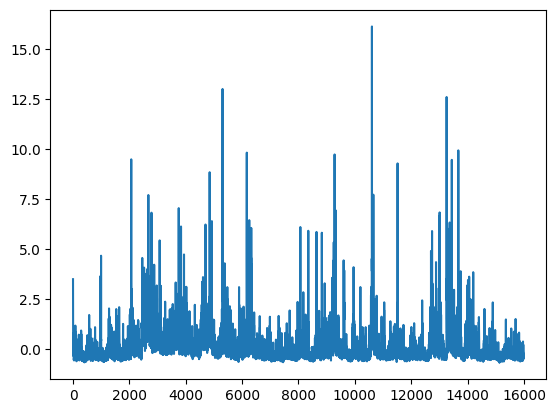

In [16]:
y_preds = elastic.predict(train_data[features].iloc[cutoff:])
plt.plot(y_preds)

In [17]:
from sklearn.metrics import r2_score

y_true = train_data["Y2"].iloc[64000:].to_numpy()
r2 = r2_score(y_true, y_preds)
print(f"R^2 = {r2:.6f}")
#.596353


R^2 = 0.596304


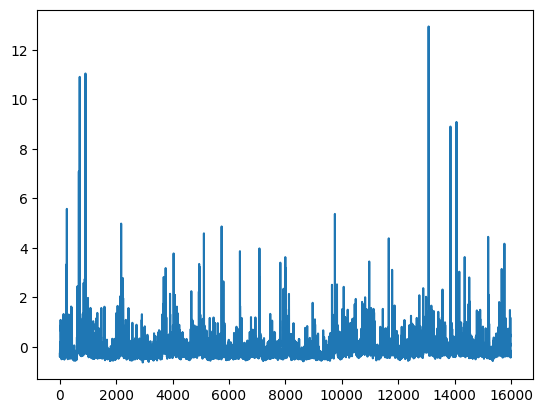

In [77]:
y_preds = elastic.predict(test_data[features])
plt.plot(y_preds)

In [78]:
df = pd.read_csv('submission.csv')
df['Y2'] = y_preds
df.head()

,id,Y1,Y2
0,1,0.384675,-0.285827
1,2,-0.207784,-0.409554
2,3,-0.196484,-0.253762
3,4,-0.370453,-0.090306
4,5,-0.880739,-0.101569


In [80]:
df.to_csv('submission2.csv', index = False)